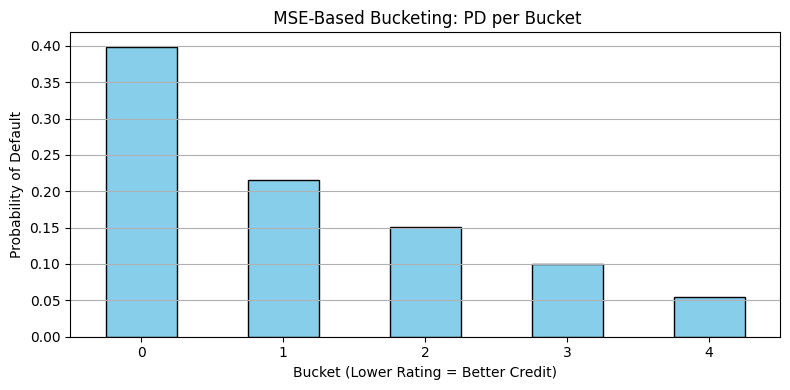

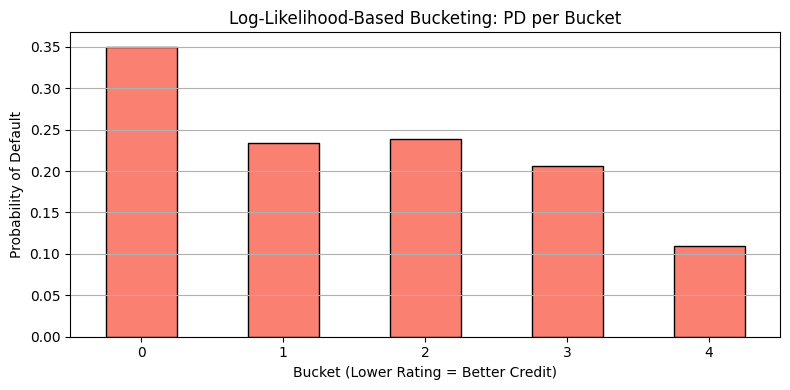

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Task 3 and 4_Loan_Data (1).csv")
df = df.dropna(subset=["fico_score", "default"])
df["fico_score"] = df["fico_score"].astype(int)
df["default"] = df["default"].astype(int)

def mse_bucketing(scores, n_buckets):
    sorted_scores = np.sort(scores.values)
    total_points = len(sorted_scores)
    bucket_size = total_points // n_buckets

    boundaries = []
    labels = np.zeros(total_points, dtype=int)
    for i in range(n_buckets):
        start = i * bucket_size
        end = (i + 1) * bucket_size if i < n_buckets - 1 else total_points
        bucket = sorted_scores[start:end]
        boundaries.append((bucket[0], bucket[-1]))
        labels[start:end] = i

    label_map = pd.cut(scores, bins=[b[0] for b in boundaries] + [boundaries[-1][1] + 1], labels=False, include_lowest=True)
    return label_map, boundaries

mse_labels, mse_boundaries = mse_bucketing(df["fico_score"], n_buckets=5)
df["mse_bucket"] = mse_labels
mse_pd = df.groupby("mse_bucket")["default"].mean()

plt.figure(figsize=(8, 4))
mse_pd.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title(" MSE-Based Bucketing: PD per Bucket")
plt.xlabel("Bucket (Lower Rating = Better Credit)")
plt.ylabel("Probability of Default")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


def log_likelihood_bucket_score(ni, ki):
    if ni == 0 or ki == 0 or ki == ni:
        return 0
    pi = ki / ni
    return ki * np.log(pi) + (ni - ki) * np.log(1 - pi)

def greedy_loglik_bucketing(df, score_col, default_col, n_buckets):
    sorted_df = df.sort_values(score_col).reset_index(drop=True)
    thresholds = []
    used_splits = set()

    for _ in range(n_buckets - 1):
        best_gain = -np.inf
        best_split = None
        for split in sorted_df[score_col].unique()[1:-1]:
            if split in used_splits:
                continue

            left = sorted_df[sorted_df[score_col] <= split]
            right = sorted_df[sorted_df[score_col] > split]

            if len(left) == 0 or len(right) == 0:
                continue

            ll_left = log_likelihood_bucket_score(len(left), left[default_col].sum())
            ll_right = log_likelihood_bucket_score(len(right), right[default_col].sum())
            gain = ll_left + ll_right

            if gain > best_gain:
                best_gain = gain
                best_split = split

        if best_split is not None:
            thresholds.append(best_split)
            used_splits.add(best_split)

    bins = [-np.inf] + sorted(set(thresholds)) + [np.inf]
    df["loglik_bucket"] = pd.cut(df[score_col], bins=bins, labels=False, duplicates='drop')
    bucket_pd = df.groupby("loglik_bucket")[default_col].mean()
    return df["loglik_bucket"], bins, bucket_pd

loglik_labels, loglik_boundaries, loglik_pd = greedy_loglik_bucketing(df.copy(), "fico_score", "default", 5)
df["loglik_bucket"] = loglik_labels


plt.figure(figsize=(8, 4))
loglik_pd.plot(kind="bar", color="salmon", edgecolor="black")
plt.title("Log-Likelihood-Based Bucketing: PD per Bucket")
plt.xlabel("Bucket (Lower Rating = Better Credit)")
plt.ylabel("Probability of Default")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()
